In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os


In [3]:
names = ['norm','uni','suppGP','suppGPlin']

## Error Curve ##

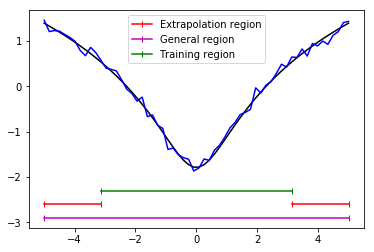

In [5]:
x = np.load('x.npy')
y = np.load('y.npy')
f = np.load('f.npy')
plt.plot(x,f,'k-')
plt.plot(x,y,'b')
plt.plot([x[0],x[11]],np.repeat(-2.6,2),'r|-')
plt.plot([x[48],x[59]],np.repeat(-2.6,2),'r|-',label='Extrapolation region')
plt.plot([x[0],x[59]],np.repeat(-2.9,2),'m|-',label='General region')
plt.plot([x[11],x[48]],np.repeat(-2.3,2),'g|-',label='Training region')
plt.legend()
plt.savefig("Input.png")
plt.show()

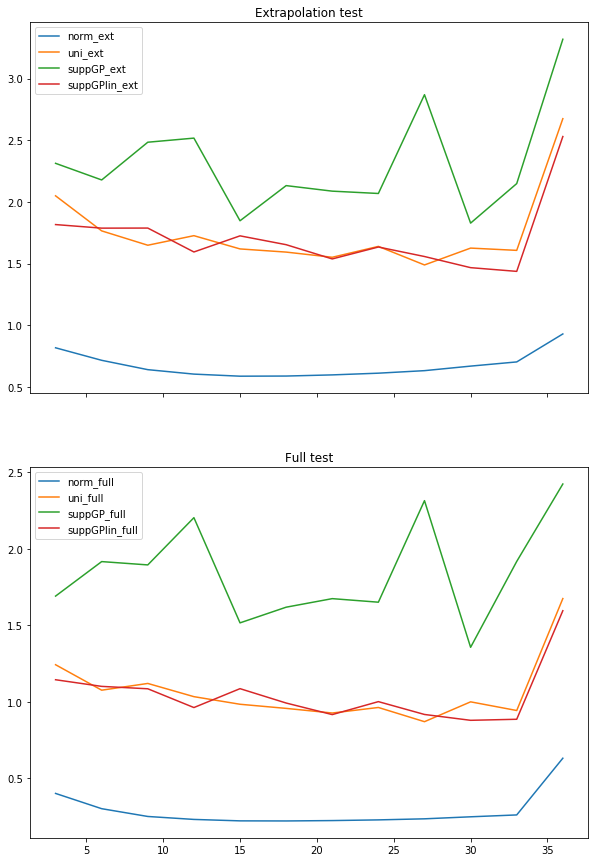

In [6]:
avgs = np.zeros((41,4,2))

names = ['norm','uni','suppGP','suppGPlin']



err_values = np.zeros((2,4,12,400))
x_vals = np.array(range(3,38,3))
for mod in range(4):
    for tpt in range(len(x_vals)):
        for a in range(1,401):
            inpfile = open('./RUN/extrapolation_%s/%s_%d_%d.txt'%(names[mod],names[mod],x_vals[tpt],a),'r')
            values = inpfile.read()
            arrr = values.splitlines()
            err_values[0,mod,tpt-1,a-1] = float(arrr[0])
            err_values[1,mod,tpt-1,a-1] = float(arrr[1])
            inpfile.close()
        
#         err_values[0,mod,tpt-1] = err_values[0,mod,tpt-1]/400.0
#         err_values[1,mod,tpt-1] = err_values[1,mod,tpt-1]/400.0
            

            
            
fig,ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(10,15)         
ax[0].set_title("Extrapolation test")
ax[1].set_title("Full test")
                
for i in range(4):
    ax[0].plot(x_vals,np.mean(err_values[0,i,:], axis=1),label=names[i]+'_ext')
    ax[1].plot(x_vals,np.mean(err_values[1,i,:], axis=1),label=names[i]+'_full')
    ax[0].legend()
    ax[1].legend()

plt.savefig("Error Curve.png")
plt.show()

(array([116.,  29.,  22.,  24.,  49.,  37.,  37.,  40.,  21.,  12.,   4.,
          6.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([7.43220962e-03, 4.25453585e-01, 8.43474961e-01, 1.26149634e+00,
        1.67951771e+00, 2.09753909e+00, 2.51556046e+00, 2.93358184e+00,
        3.35160321e+00, 3.76962459e+00, 4.18764597e+00, 4.60566734e+00,
        5.02368872e+00, 5.44171009e+00, 5.85973147e+00, 6.27775284e+00,
        6.69577422e+00, 7.11379560e+00, 7.53181697e+00, 7.94983835e+00,
        8.36785972e+00, 8.78588110e+00, 9.20390247e+00, 9.62192385e+00,
        1.00399452e+01, 1.04579666e+01, 1.08759880e+01, 1.12940094e+01,
        1.17120307e+01, 1.21300521e+01, 1.25480735e+01]),
 <a list of 30 Patch objects>)

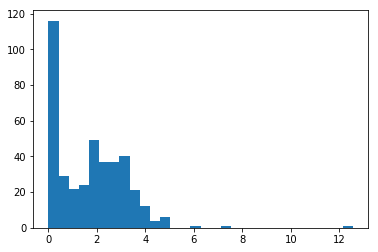

In [30]:
plt.hist(err_values[0,3,4],30)

## Full fit ##

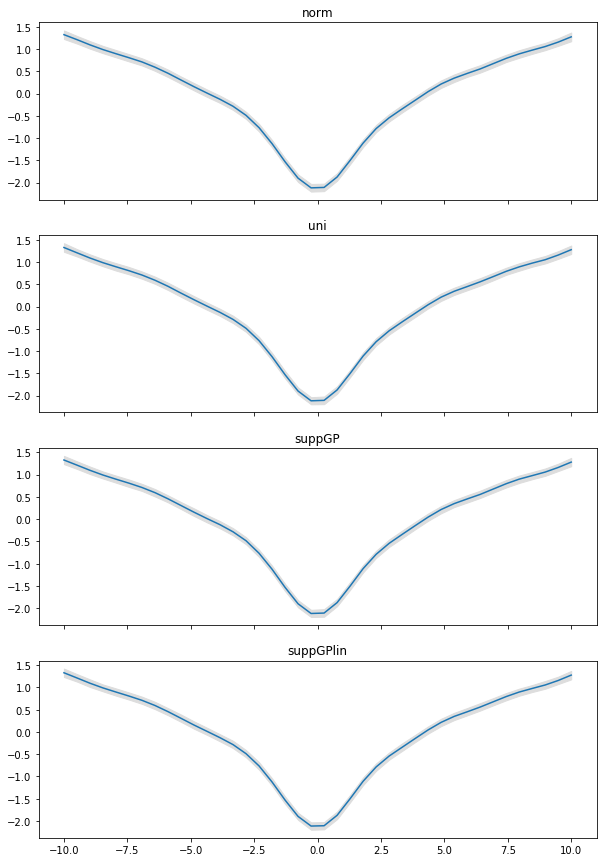

In [21]:

avgs = np.zeros((41,4,2))

names = ['norm','uni','suppGP','suppGPlin']
x = np.load('x.npy')

fig,ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(10,15)

for a in range(4):
    mean = np.load('./fullpred4/%s_model.npy'%(names[a]))
    q5 = np.load('./fullpred4/%s_5q.txt.npy'%(names[a]))
    q95 = np.load('./fullpred4/%s_95q.txt.npy'%(names[a]))
    ax[a].plot(x,mean)
    ax[a].fill_between(x, q5, q95, color='#dddddd')
    ax[a].set_title(names[a])

plt.show() 
plt.savefig('Posterior fit using all data points')
            

## Generate data ##

In [30]:
cnt = 60
x = np.linspace(-5,5,cnt)
np.save('x',x)

In [31]:
t = -1*scipy.stats.t.logpdf(x,1)
t = preprocessing.scale(t)
np.save('f',t)

In [32]:
y = t + np.random.normal(0,0.1,cnt)
np.save('y',y)

(1.8644067796610169, 1.8644067796610173)


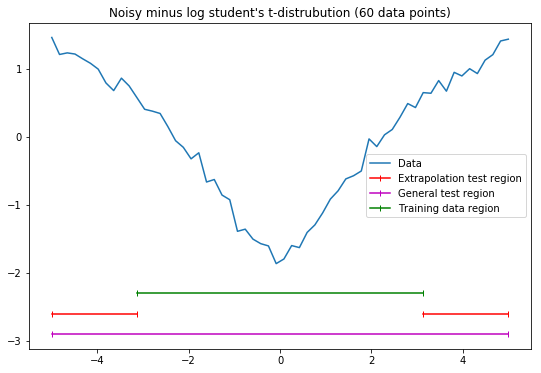

In [34]:
fig = plt.figure(figsize=(9,6))
plt.plot(x,y,label='Data')
print(x[11]-x[0],x[59]-x[48])
plt.plot([x[0],x[11]],np.repeat(-2.6,2),'r|-')
plt.plot([x[48],x[59]],np.repeat(-2.6,2),'r|-',label='Extrapolation test region')
plt.plot([x[0],x[59]],np.repeat(-2.9,2),'m|-',label='General test region')
plt.plot([x[11],x[48]],np.repeat(-2.3,2),'g|-',label='Training data region')
plt.legend()
plt.title('Noisy minus log student\'s t-distrubution (%d data points)'%cnt)
plt.savefig('Input distribution')

### Post Mortem ###

In [5]:
x = np.load('x.npy')
for mod  in [0,2,3]:
    os.makedirs('./postmortem2_%s_fit'%(names[mod]))
    for i in range(3,38,3):
        for j in range (1,51):
            mean  = np.load('./postmortem2_%s/%s_%d_%d_model.npy'%(names[mod],names[mod],i,j))
            q5  = np.load('./postmortem2_%s/%s_%d_%d_5q.npy'%(names[mod],names[mod],i,j))
            q95  = np.load('./postmortem2_%s/%s_%d_%d_95q.npy'%(names[mod],names[mod],i,j))
            xused  = np.load('./postmortem2_%s/%s_%d_%d_xused.npy'%(names[mod],names[mod],i,j))
            yused  = np.load('./postmortem2_%s/%s_%d_%d_yused.npy'%(names[mod],names[mod],i,j))
            plt.figure(j)
            plt.plot(xused,yused,'ro',label='Data point')
            plt.plot(x,mean)
            plt.fill_between(x, q5, q95, color='#dddddd')
            plt.title('%s_%d_%d'%(names[mod],i,j))
            plt.legend()
            plt.savefig('./postmortem2_%s_fit/%s_%d_%d.png'%(names[mod],names[mod],i,j))
            plt.close()

print("Done ")

Done 
